In [1]:
# imports packages
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# funcao para redimensionar a imagem
def rescale_image(image, proportion, interpolation=None):
    #   avalia se o parametro que foi passado para a imagem foi um caminho para o
    #    arquivo ou uma imagem em forma de numpy array
    image_result = np.array([])
    if type(image) == str:
        image_result = cv2.imread(image)
    elif type(image) == np.ndarray:
        image_result = image
    # Se o parametro de proporção for maior que 1 será feita interpolação dependendo
    # do parametro interpolação
    if proportion >= 1:
        if interpolation == 'vizinho':
            image_result = rescale_image_neighbor(image_result, proportion)
        elif interpolation == 'bilinear':
            image_result = rescale_image_bilinear(image_result, proportion)
    
    # Esse caso se refere à redução das proporções e nesse caso trataremos de
    #  eliminar pixels
    elif proportion > 0:
        proportion_division = 1/proportion
        row, col = image_result.shape
        row_scale = [r for r in range(row) if not (int(r%proportion_division) == 0)]
        col_scale = [c for c in range(col) if not (int(c%proportion_division) == 0)]
        image = np.delete(image_result, row_scale, axis=0)
        image = np.delete(image_result, col_scale, axis=1)
    
    return image_result

In [3]:
# funcao para aumentar a proporção da imagem utilizando vizinho mais próximo
def rescale_image_neighbor(image, proportion):
    image_rescale = np.copy(image)
    # get the row, column and channel lengths
    row, col = image.shape
    new_row, new_col = [np.floor(entry*proportion) for entry in image_rescale.shape]
    row_index = 1
    resto_sum = 0
    while row_index < new_row:
        qtd_row_insert = proportion - 1
        while qtd_row_insert >= 0:
            if qtd_row_insert >= 1:
                image_rescale = np.insert(image_rescale,
                                            row_index, 
                                            image_rescale[row_index-1,:], 
                                            axis=0)
                row_index += 1
                qtd_row_insert -= 1
            elif qtd_row_insert >= 0:
                resto_sum += qtd_row_insert
                row_index += 1
                qtd_row_insert -= 1
            if resto_sum >= 1:
                image_rescale = np.insert(image_rescale, row_index, 0, axis=0)
                row_index += 1
                resto_sum -= 1
            row, _ = image_rescale.shape

    col_index = 1
    resto_sum = 0
    while col_index < new_col:
        qtd_col_insert = proportion - 1
        while qtd_col_insert >= 0:
            if qtd_col_insert >= 1:
                image_rescale = np.insert(image_rescale,
                                          col_index,
                                          image_rescale[:,col_index-1],
                                          axis=1)
                col_index += 1
                qtd_col_insert -= 1
            elif qtd_col_insert >= 0:
                resto_sum += qtd_col_insert
                col_index += 1
                qtd_col_insert -= 1
            if resto_sum >= 1:
                image_rescale = np.insert(image_rescale,
                                          col_index,
                                          image_rescale[:,col_index-1],
                                          axis=1)
                col_index += 1
                resto_sum -= 1
            _, col = image_rescale.shape
            
    return image_rescale

In [27]:
# funcao para aumentar a proporção da imagem utilizando vizinho mais próximo
def rescale_image_bilinear(image, proportion):
    image_rescale = np.copy(image)
    # get the row, column and channel lengths
    row, col = image.shape
    new_row, new_col = [np.floor(entry*proportion) for entry in image_rescale.shape]
    row_index = 1
    resto_sum = 0
    while row_index < new_row:
        qtd_row_insert = proportion - 1
        while qtd_row_insert >= 0:
            if qtd_row_insert >= 1 and row_index + 1 < image_rescale.shape[0]:
                row_mean_result = [np.mean([image_rescale[row_index-1,index],
                                            image_rescale[row_index+1,index]])
                                   for index in range(len(image_rescale[row_index,:]))]
                image_rescale = np.insert(image_rescale,
                                            row_index, 
                                            row_mean_result, 
                                            axis=0)
                row_index += 1
                qtd_row_insert -= 1
            elif qtd_row_insert >= 0:
                resto_sum += qtd_row_insert
                row_index += 1
                qtd_row_insert -= 1
            if resto_sum >= 1 and row_index + 1 < image_rescale.shape[0]:
                row_mean_result = [np.mean([image_rescale[row_index-1,index],
                                            image_rescale[row_index+1,index]])
                                   for index in range(len(image_rescale[row_index,:]))]
                image_rescale = np.insert(image_rescale, 
                                          row_index,
                                          row_mean_result,
                                          axis=0)
                row_index += 1
                resto_sum -= 1
            row, _ = image_rescale.shape

    col_index = 1
    resto_sum = 0
    while col_index < new_col:
        qtd_col_insert = proportion - 1
        while qtd_col_insert >= 0:
            if qtd_col_insert >= 1 and col_index + 1 < image_rescale.shape[1]:
                col_mean_result = [np.mean([image_rescale[index,col_index-1],
                                            image_rescale[index,col_index+1]])
                                   for index in range(len(image_rescale[:,col_index]))]
                image_rescale = np.insert(image_rescale, 
                                          col_index,
                                          col_mean_result,
                                          axis=1)
                col_index += 1
                qtd_col_insert -= 1
            elif qtd_col_insert >= 0:
                resto_sum += qtd_col_insert
                col_index += 1
                qtd_col_insert -= 1
            if resto_sum >= 1 and col_index + 1 < image_rescale.shape[1]:
                col_mean_result = [np.mean([image_rescale[index,col_index-1],
                                            image_rescale[index,col_index+1]])
                                   for index in range(len(image_rescale[:,col_index]))]
                image_rescale = np.insert(image_rescale, col_index, 0, axis=1)
                col_index += 1
                resto_sum -= 1
            _, col = image_rescale.shape
            
    return image_rescale

In [5]:
# Padding image to run the algorithm
def pad_image(image_pi, type_pad, rgb=False):
    # If image is rgb make a frame of pixel taken from the edge of the image
    # for each color
    if rgb:
        im_padded = [np.pad(original_image[:,:,i], 1, type_pad)
                     for i in range(original_image.shape[-1])]
        im_padded = [np.expand_dims(image_p, axis=2) for image_p in im_padded]
        return np.concatenate(im_padded, axis=2)
    # If image is rgb make a frame of pixel taken from the edge of the image
    else:
        return np.copy(np.pad(image_pi, 1, type_pad))

In [6]:
# Mostrar imagens
def show_subplots_image(image_array, nrow, ncol,fig_size_array, 
                        title_array, cmap=None):
    fig, axes = plt.subplots(nrow, ncol, figsize=fig_size_array)
    for ax, image, title in zip(axes.flatten(), image_array, title_array):
        ax.axis('off')
        ax.set_title(title)
        fig.tight_layout()
        ax.imshow(image, cmap=cmap)

b) Utilize o sua função do item anterior para gerar imagens com resolução espacial reduzida por fatores de 2, 4, 8 e 16. Em seguida, utilize o seu programa novamente para aumentar estas imagens de volta ao seu tamanho original. Há diferenças de qualidade entre estas imagens? Comente. (Obs.: Plote os resultados para que possam se visualizados).

In [7]:
# carregar imagem, converter para RGB e normaliza-la
original_image = cv2.imread('../imagens/image.jpg', cv2.IMREAD_GRAYSCALE)
# original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
# original_image = \
#     (original_image - np.min(original_image))/ \
#     (np.max(original_image) - np.min(original_image))

In [8]:
proportion_list = [1/2, 1/4, 1/8, 1/16]
title_array = ['1/2 da Imagem', '1/4 da Imagem', '1/8 da Imagem', '1/16 da Imagem']
imagem_reduce_array = [rescale_image(original_image, proportion=proportion, )
                       for proportion in proportion_list]

In [9]:
def redifine_image_reduce_to_show_scale(image_rirtds, image_reference):
    image_redefine = np.copy(image_rirtds)
    image_result = list()
    for image_idx, image_resize in enumerate(image_redefine):
        image_ones = np.ones(image_reference.shape)
        for i in range(image_ones.shape[0]):
            for j in range(image_ones.shape[1]):
                if i < image_resize.shape[0] and j < image_resize.shape[1]:
                    image_ones[i,j] = image_resize[i,j]
                else:
                    image_ones[i,j] = image_reference[i,j]
        image_result.append(image_ones)
    return image_result

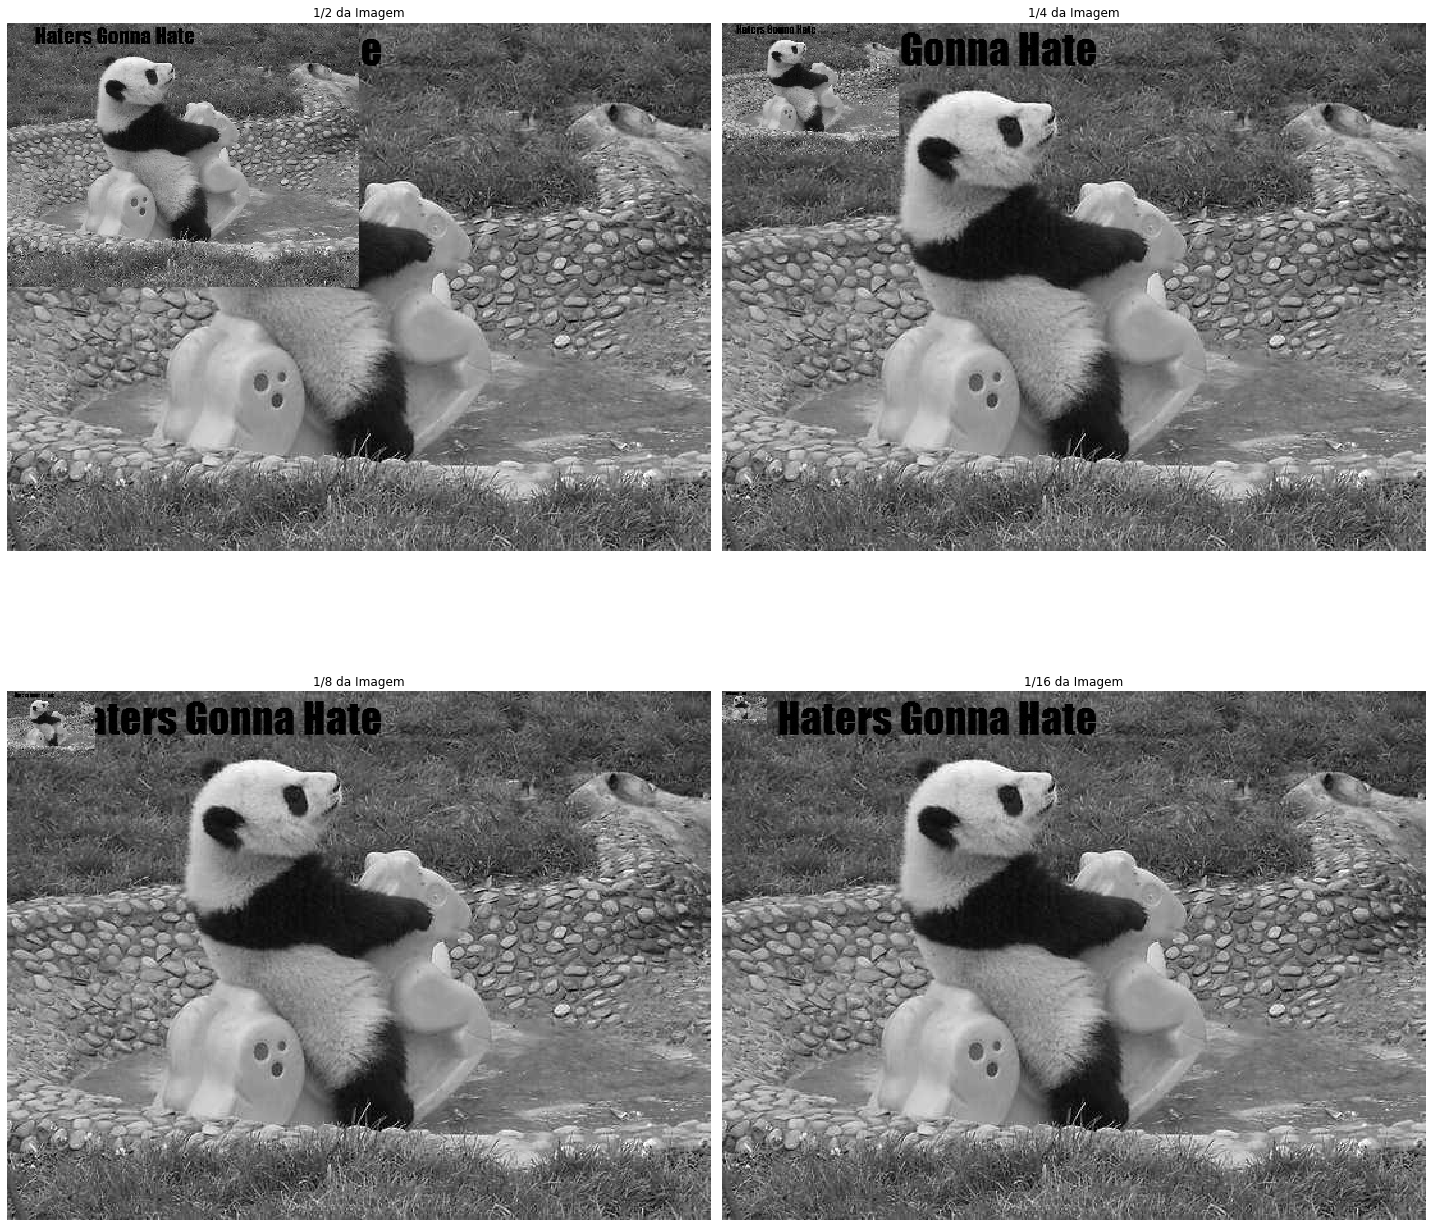

In [10]:
# Show images
image_to_plot_reduce = redifine_image_reduce_to_show_scale(imagem_reduce_array,
                                                           original_image)
IMAGE_SIZE=[20,20]
show_subplots_image(image_to_plot_reduce, 2, 2, IMAGE_SIZE,
                    title_array=title_array, cmap='gray')

In [11]:
proportion_expand_list = [2, 4, 8, 16]
expand_proportion = zip(imagem_reduce_array, proportion_expand_list)
imagem_vizinho = \
    [rescale_image(im_expand, proportion=proportion, interpolation='vizinho')
     for im_expand, proportion in expand_proportion]

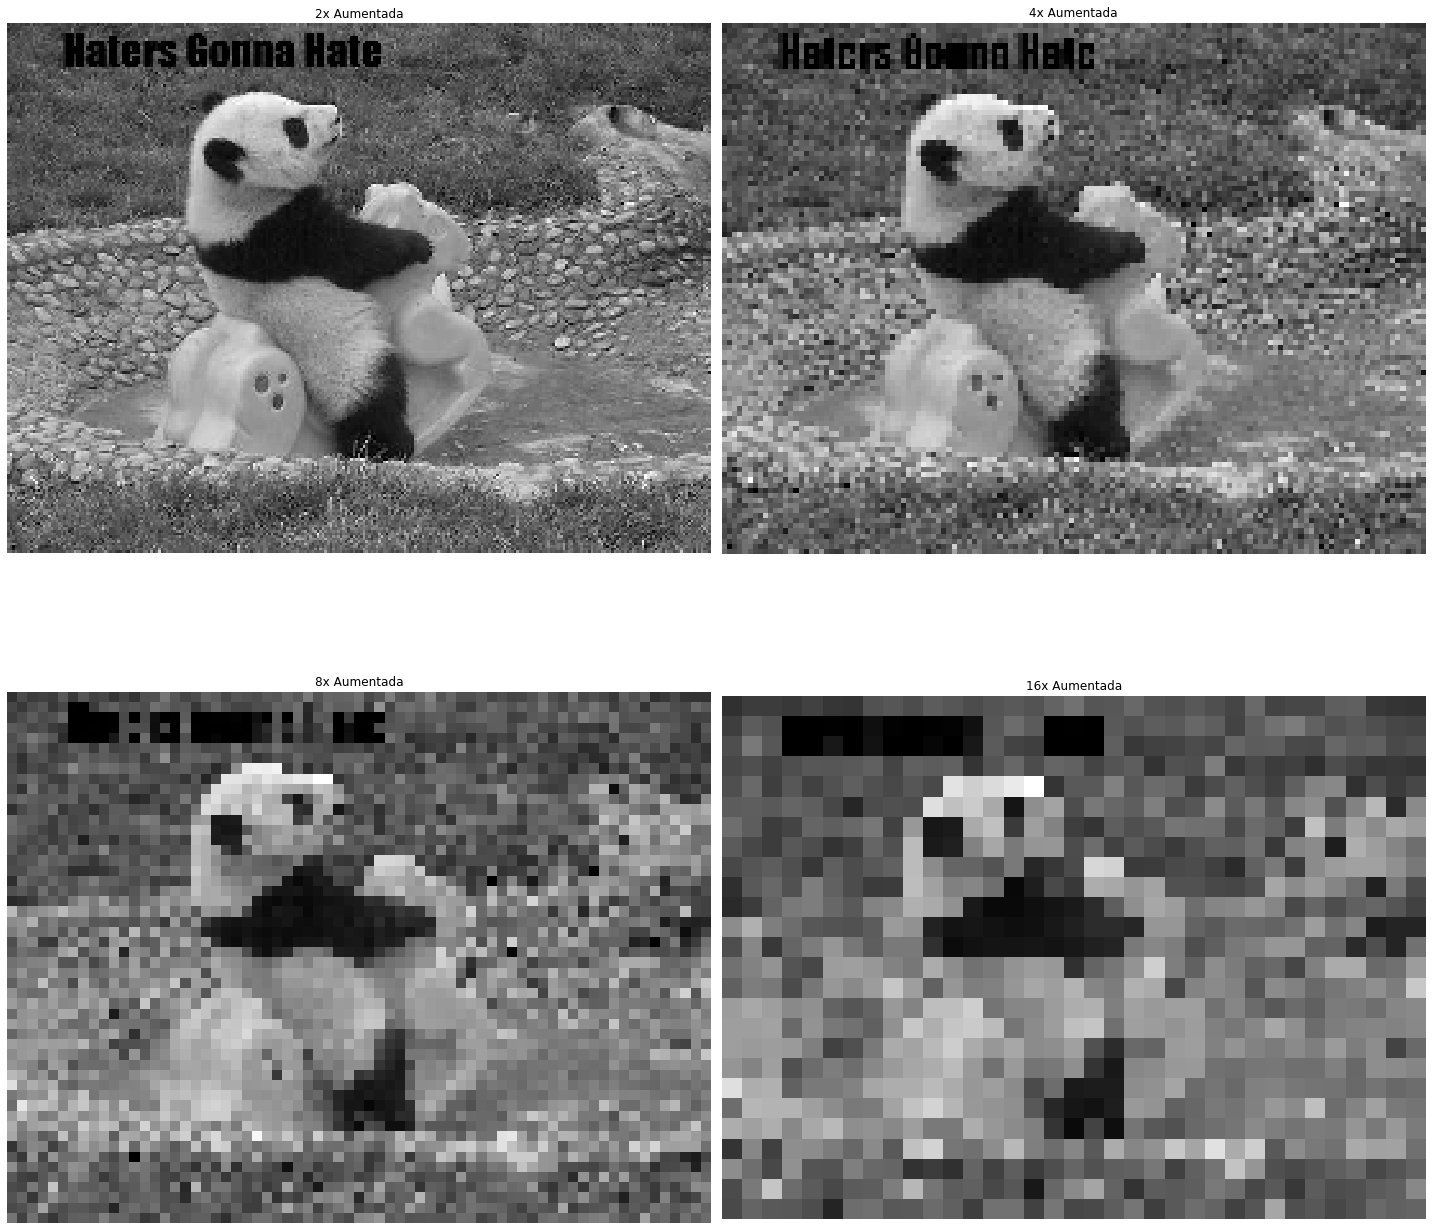

In [17]:
# Show images
title_expand = ['2x Aumentada', '4x Aumentada', '8x Aumentada', '16x Aumentada']
show_subplots_image(imagem_vizinho, 2, 2, IMAGE_SIZE, title_expand, 'gray')

c) Modifique a função desenvolvida em (a), de forma que seja utilizada a técnica de interpolação bilinear e refaça o que se pede no item (b) novamente. (Obs.: Plote os resultados para que possam se visualizados). 

In [31]:
expand_proportion_bilinear = zip(imagem_reduce_array, proportion_expand_list)

In [32]:
imagem_bilinear = \
    [rescale_image(im_expand, proportion=proportion, interpolation='bilinear')
     for im_expand, proportion in expand_proportion_bilinear]

In [40]:
print(imagem_reduce_array[0][0], imagem_reduce_array[0][1])

[ 48  72  57  68  75  56  69  55  61 102  50  75  66  86  68  55  60  69
  68  68  88  70  70  61  56  71  99  47  85  69  58  66  65  56  62  27
  71  49  89  65  54  72  66  73  69  64  54  65  53 106 104  62  81  64
  74  77  81 101  80  86 117  94 110  91  86  75  72  74  69 126  56  84
  76 100  85  96  99 116  92  77  92  72  94  85  71  90  76  81  86  74
  85  79  81  87  77  84  76 101  90  77  88 119  93  98  84 103  89 108
 101 122  98 100  90 139  99 100 123  61  84  93  83  88  74  89 102  91
  75 104  99  96 104  97 101  70  74 102 113  87 105  87  74 103  85  61
  85  88 117  79 125  74  95  93  87  91  97 106  80  99  75  83 104  96
 113  90 130  98 126 108  83 103 104 104 101  85  83 110  79  84  97  67
  79  58  44  69  88  88  92  80  69  85 115  93  79  83  88  94  68  92
  43  55  69  70  64  64  81 113 104 107 105  93 110 123  77 113 109  91
  67  88  60  84 115  74  64  78  71  76 101  61  80  69  78  41  71 104
  86  84  57 105  95 108  94  82  71  45  79 101  7

In [43]:
print(imagem_bilinear[0][2], imagem_bilinear[0][1])

[ 76  69  53  59  63  64  65  65  66  76  66  76  86  89  87  88  93  90
  89  91  87  83  94  83  79  78  72  78  77  82  84  77  88  81  71  73
  75  69  75  76  63  69  77  71  76  65  66  69  55  65  72  72  76  61
  73  58  47  48  44  54  49  62  64  73  76  67  83  94  59  66 105  98
  74  62  92  66  51  52  40  40  53  44  41  51  36  48  62  72  61  63
  82  78  66  90  74  80 115 102  87  79  90  78  71  65  66  68  60  66
  71  72  72  88  74  78 105  90  82  71  76  74  60  71  73  75  82  85
  77  75  89  76  73  69  63  65  66  75  67  82  84  75  98  83  66  72
  68  71  78  88  75  94  98  99 114 102 101 100  91 101 100  97 111  89
  95  97  68  83 100  88  98  96  76  79  95  81  82  73  68  71  64  70
  75  83  77  84  92  89  91  95  87  96 100 108 105 111 116  98 118  99
  81  81  80  93  82  94 107 101 106 104  95  93 103 109  92  94 116 108
  96  99 101 104 102 102 107 113 103  99 119 114  95 104 109  98 113 110
  87  93 108  99 100 104  91  89 108 104  87  94 10

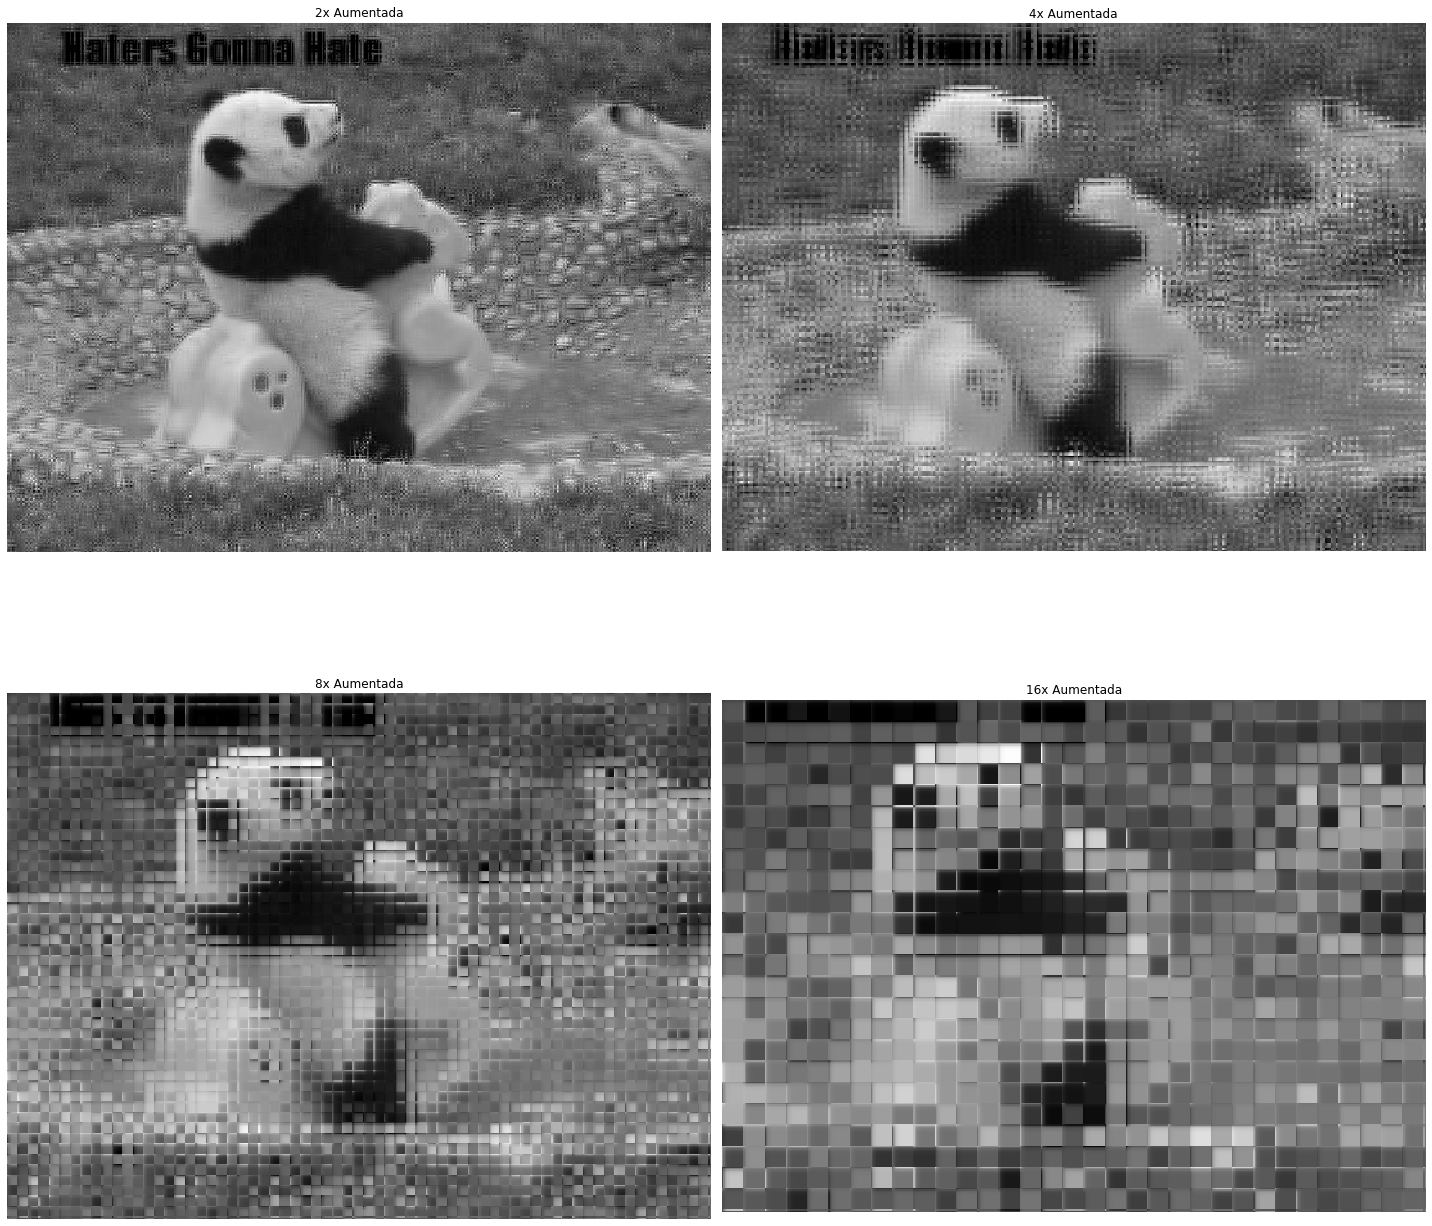

In [34]:
# Show images
show_subplots_image(imagem_bilinear, 2, 2, IMAGE_SIZE, title_expand, 'gray')